# Estimating Hyperparameters From Data

Initial tracking data is noisy and contains a number of error values that occur when the tracking code reports a low quality of fit (reflected by a very wide gaussian needed to try and fit the LED signal in a particular color channel). We can also identify poor tracking using the distance between LEDs, which should always be within a biologically plausible range. The code here is designed to check that range of plausible distances and to visualize the distribution of fit metrics in order to establish a threshold from which to exclude frames in which we have low confidence in the tracking.

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, str(Path.cwd().parent))

import loading as vload                 # Local modules from repo
import loading as vplot
import transform as vtran


In [2]:
# Load data from all the sessions on which we used Matlab to track LEDs (this is ~50 million frames, so can take a minute)
file_path = '~/Data/Task_Switching/head_tracking/LED_positions/LED_data_221005_1454.parquet'

df = vload.load_matlab_parquet(file_path)
print(df.shape)

(49049030, 9)


## Visualize the quality of fit for all data

Quality of fit is measured using the ratio between the amplitude and standard deviation of the gaussian fitted to the LED signal in each image. Larger values indicate better fit. The values are averaged across x and y axes, for which gaussians are fit indepenently.

For consistency with the DeepLabCut measure of fit quality, we call this "Likelihood" but it doesn't have any connection to the statistical measure from Bayes (maybe we should thus rename it).

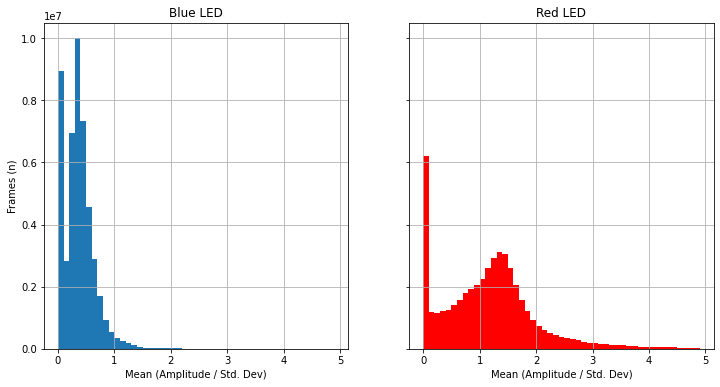

In [4]:
# Plot bin data
bins = np.arange(0, 5, 0.1)

fig, axs = plt.subplots(1, 2, sharey=True, **{'figsize':(12,6)})

df['blue_LEDlikelihood'].hist(bins=bins, ax=axs[0])
df['red_LEDlikelihood'].hist(bins=bins, ax=axs[1],**{'color':'r'})

axs[0].set_title('Blue LED')
axs[1].set_title('Red LED')

axs[0].set_ylabel('Frames (n)')

axs[0].set_xlabel('Mean (Amplitude / Std. Dev)')
axs[1].set_xlabel('Mean (Amplitude / Std. Dev)')

plt.show()
# plt.savefig('Methods/video_tracking/images/first_pass_fit.png')
# plt.close()

## Visualizing LED separation

* Remove poor quality data (based on the above histograms, we select a minimum threshold of 0.2)
* Compute distance between LEDs
* Plot distribution of distances

Note, we plot the LED separation after considering the quality of data in step 1 rather than before it, as we explicitly expect there to be poor quality tracking in some conditions (e.g. when the animal is only partly in view).

In [5]:
# Remove values which we have little confidence in
df = vtran.filter_for_low_likelihoods(df, threshold=0.2)
df = df.dropna().drop(columns=['blue_LEDlikelihood', 'red_LEDlikelihood'])

print(df.shape)

(31623865, 7)


In [6]:
# Compute distance between red and blue LEDs on each frame
df = df.assign(distance = lambda x: np.sqrt((x.blue_LEDy - x.red_LEDy)**2 + (x.blue_LEDx - x.red_LEDx)**2))

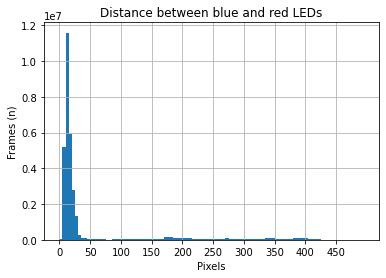

In [7]:
# Draw histogram showing distribution of distances
ax = df['distance'].hist(bins=np.arange(0, 500, 5))
ax.set_xticks(np.arange(0,500,50))
ax.set_xlabel('Pixels')
ax.set_ylabel('Frames (n)')
ax.set_title('Distance between blue and red LEDs')

# plt.savefig('Methods/video_tracking/images/first_pass_red_blue_distance.png')
# plt.close()
plt.show()